In [1]:
#import sys
import sys
import os
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
from numpy import double as npdouble

import Ska.engarchive.fetch_eng as fetch
from Chandra.Time import DateTime


home = expanduser("~")
addthispath = home + '/AXAFLIB/pyeclipse/'
sys.path.append(addthispath)
import pyeclipse as ecl

from re import split as resplit
# Use this if you want to be able to zoom or easily save a plot:
%matplotlib notebook

In [2]:
def read_eclipse_file(filename):

    def parse_line(line):
        words = line.split()
        starttime = words[0][4:] + ':' + words[0][:3] + ':' + words[1]
        stoptime = words[2][4:] + ':' + words[2][:3] + ':' + words[3]

        returndict = {'Start Time': starttime,
                      'Stop Time': stoptime,
                      'Duration': words[4],
                      'Current Condition': words[5],
                      'Obstruction': words[6],
                      'durationsec': npdouble(words[4]),
                      'startsec': DateTime(starttime).secs,
                      'stopsec': DateTime(stoptime).secs}

        if len(words) == 9:
            returndict.update({'Entry Timer': words[7],
                               'timersec': npdouble(words[7]),
                               'Type': words[8]})

        return returndict

    with open(filename, 'r', encoding='utf-8') as fid:
        datalines = fid.readlines()

    # The first line includes the year and day the file was generated
    #
    # Note: This entry may be manually created and could be a source of error
    # if read incorrectly.
    words = datalines.pop(0).split()

    if 'Epoch' in words:
        # Standard ECLIPSE.txt format
        year, dayofyear = words[-2].split('/')
        eclipse = {'epoch': {'year': year, 'doy': dayofyear}}


    else:
        # Possibly a manually formatted version
        eclipse = {'epoch': {'year': words[2]}}
        eclipse['epoch'].update({'dom': words[0]})
        eclipse['epoch'].update({'month': words[1]})
        eclipse['epoch'].update({'time': words[3]})

        hosc = DateTime(words[2] + words[1] + words[0] + ' at ' + words[3]).date
        eclipse['epoch'].update({'doy': hosc[5:8]})

    # Remove initial spacing lines
    line = datalines.pop(0)
    while len(line.strip()) < 50:
        line = datalines.pop(0)

    headers = resplit("\s{2,5}", line.strip())

    # Truncate the Start Time, Stop Time and Duration header names
    headers[0] = headers[0][:10]
    headers[1] = headers[1][:9]
    headers[2] = headers[2][:8]

    # Remove the dashed lines separating the header from the eclipse data entries
    line = datalines.pop(0)

    # This is the eclipse number; it is used to index all eclipses in the
    # file. It has no other significance.
    n = -1
    eclipse.update({'eclipse_nums': []})

    while len(datalines) > 0:
        line = datalines.pop(0).strip()

        # All eclipse entries start wth at least 7 "words"
        if len(line.split()) >= 7:

            # increment the eclipse number and create a placeholder dict
            n = n + 1
            eclipse['eclipse_nums'].append(n)
            eclipse.update({n: {}})

            # Add the entrance penumbra data, there will always be an entrance
            # penumbra
            eclipsedata = parse_line(line)
            eclipse[n].update({'entrancepenumbra': eclipsedata})

            # If this is a full eclipse, then there will also be umbra and
            # exit penumbra phases.
            if len(datalines) > 0:
                if 'Umbra' in datalines[0]:

                    line = datalines.pop(0)
                    eclipsedata = parse_line(line)
                    eclipse[n].update({'umbra': eclipsedata})

                    line = datalines.pop(0)
                    eclipsedata = parse_line(line)
                    eclipse[n].update({'exitpenumbra': eclipsedata})

    return eclipse

def convert_eclipse_times(eclipse):
    for n in eclipse['eclipse_nums']:
        if n != 'epoch':
            for m in eclipse[n].keys():
                eclipse[n][m].update({'durationsec':
                                      npdouble(eclipse[n][m]['Duration'])})
                eclipse[n][m].update({'startsec':
                                      DateTime(eclipse[n][m]['Start Time']).secs})
                eclipse[n][m].update({'stopsec':
                                      DateTime(eclipse[n][m]['Stop Time']).secs})
                if m == 'entrancepenumbra':
                    if 'Entry Timer' in eclipse[n][m].keys():
                        eclipse[n][m].update({'timersec':
                                              npdouble(eclipse[n][m]
                                                       ['Entry Timer'])})
    return eclipse

def read_altitude(filename='altitude_prediction.txt'):
    fin = open(filename, 'r', encoding='utf-8')
    datalines = fin.readlines()
    fin.close()
    altitude = np.array([npdouble(line.strip().split()[1]) for line in datalines])
    times = np.array([DateTime(line.strip().split()[0]).secs for line in datalines])
    return (times, altitude)


def read_comms(filename, numheaderlines, year):

    fin = open(filename, 'r', encoding='utf-8')
    datalines = fin.readlines()
    fin.close()
    [datalines.pop(0) for n in range(numheaderlines)]

    year = str(year)

    fieldnames = ('day', 'start', 'bot', 'eot', 'end', 'facility', 'user',
                  'endocde2', 'endcode1', 'config', 'passno', 'activity',
                  'tstart', 'tbot', 'teot', 'tend')

    commdata = {}

    k = -1
    while len(datalines) > 0:
        if datalines[0][0] != '*':
            if len(datalines[0].strip()) > 20:
                k = k + 1

                words = datalines.pop(0).strip().split()
                try:
                    day = words.pop(0)
                except:
                    import readline  # optional, will allow Up/Down/History in the console
                    import code
                    vars = globals().copy()
                    vars.update(locals())
                    shell = code.InteractiveConsole(vars)
                    shell.interact()
                start = words.pop(0)
                bot = words.pop(0)
                eot = words.pop(0)
                end = words.pop(0)
                facility = words.pop(0)
                user = words.pop(0)
                endcode2 = words.pop(-1)
                endcode1 = words.pop(-1)
                config = words.pop(-1)
                passno = words.pop(-1)
                activity = ' '.join(words)

                yearday = year + ':' + day + ':'
                tstart = DateTime(yearday + start[:2] + ':' + start[2:] + ':00.000').secs
                tbot = DateTime(yearday + bot[:2] + ':' + bot[2:] + ':00.000').secs
                teot = DateTime(yearday + eot[:2] + ':' + eot[2:] + ':00.000').secs
                tend = DateTime(yearday + end[:2] + ':' + end[2:] + ':00.000').secs

                if npdouble(bot) < npdouble(start):
                    tbot = tbot + 24 * 3600
                    teot = teot + 24 * 3600
                    tend = tend + 24 * 3600
                elif npdouble(eot) < npdouble(bot):
                    teot = teot + 24 * 3600
                    tend = tend + 24 * 3600
                elif npdouble(end) < npdouble(eot):
                    tend = tend + 24 * 3600

                passinfo = (day, start, bot, eot, end, facility, user, endcode2,
                            endcode1, config, passno, activity, tstart, tbot, teot,
                            tend)

                commdata.update(dict({k: dict(zip(fieldnames, passinfo))}))

        junk = datalines.pop(0)

    return commdata


In [3]:
eclipse = read_eclipse_file(filename='ECLIPSE.txt')

eclipse = convert_eclipse_times(eclipse)

# altdata = fetch.Msid('dist_satearth', '2017:340', '2018:001', stat='5min')
# talt = altdata.times
# alt = altdata.vals
talt, alt = read_altitude(filename='altitude.txt')

minbool,maxbool = ecl.find_extrema(talt, alt)



In [4]:

commdata1 = read_comms('2017-51-52-CHDR_20170725145350.7da.txt', 9, 2017)
bot1 = np.array([commdata1[n]['tbot'] for n in commdata1.keys()])  
eot1 = np.array([commdata1[n]['teot'] for n in commdata1.keys()])

commdata2 = read_comms('2018-01-CHDR_20170725153944.7da.txt', 9, 2018)
bot2 = np.array([commdata2[n]['tbot'] for n in commdata2.keys()])  
eot2 = np.array([commdata2[n]['teot'] for n in commdata2.keys()])

eot = np.array(list(eot1) + list(eot2))
bot = np.array(list(bot1) + list(bot2))
list(zip(DateTime(bot).date, DateTime(eot).date))

commdata = commdata1

m = len(commdata1)
for n in range(len(commdata2)):
    commdata[n + m] = commdata2[n]

In [5]:
# ignore the first and last since they likely are not orbit mins or maxes
perigee = talt[minbool] 


# Find the corresponding perigee time for each eclipse, also find the two
# closest comms
for n in eclipse.keys():
    if n != 'epoch' and n != 'eclipse_nums':
        tdiff = np.abs(perigee - eclipse[n]['entrancepenumbra']['startsec'])
        minval = np.min(tdiff)
        minind = np.argmin(tdiff)
        if minval < 10*3600:
            eclipse[n].update(dict(perigee=perigee[minind]))
        else:
            print('No perigee found for eclipse %d'%n)
        dcomm = np.argsort(np.abs(eclipse[n]['entrancepenumbra']['startsec']
                                  - bot))
        eclipse[n].update(dict(comm1=commdata[dcomm[0]]))
        eclipse[n].update(dict(comm2=commdata[dcomm[1]]))

<IPython.core.display.Javascript object>


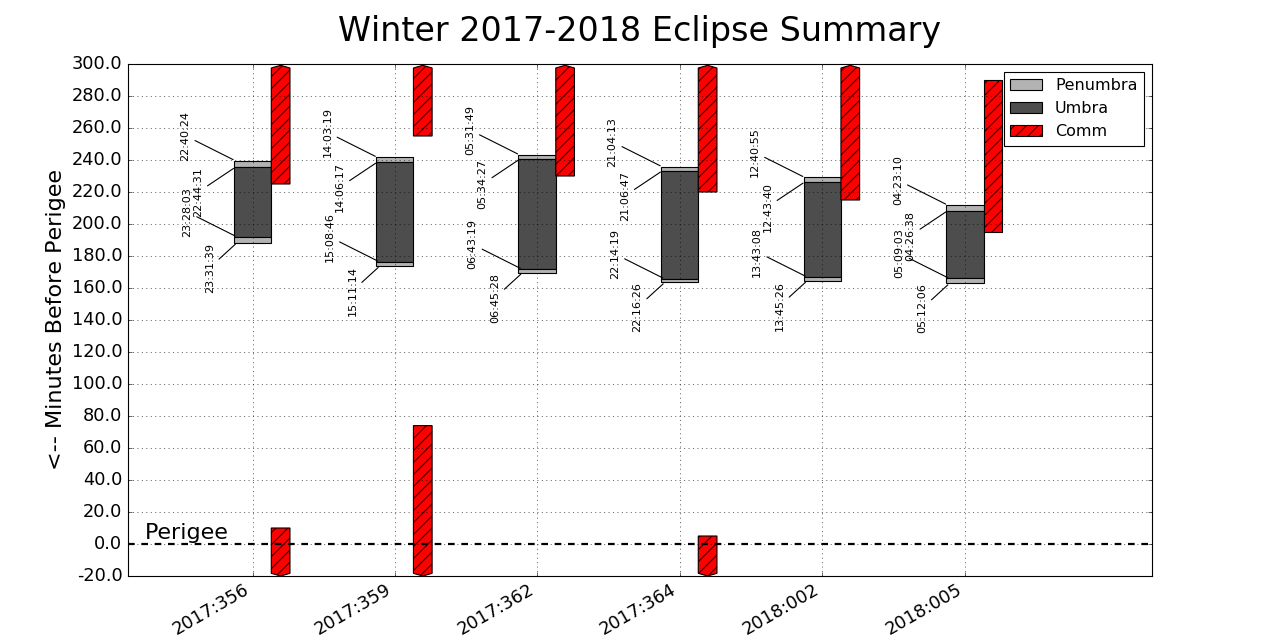

In [6]:

# -----------------------------------------------------------------------------
# Plotting Routine

mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['savefig.edgecolor'] = [1,1,.8]

#fig = plt.figure(facecolor=[1,1,1],figsize=(24,15.5))
#fig = plt.figure(facecolor=[1,1,1],figsize=(16,12))
fig = plt.figure(facecolor=[1,1,1],figsize=(16,8))

# For now, fill the figure with only one plot
# gridspec = plt.GridSpec(1,4) #,width_ratios=[1,1],height_ratios=[5,1])
# subplotspec1 = gridspec.new_subplotspec((0,0),rowspan=1,colspan=4)

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1.set_axis_bgcolor([1,1,1])

# Use this later when you want to add another plot to the figure
## subplotspec2 = gridspec.new_subplotspec((0,3),rowspan=1,colspan=1)
## ax2 = fig.add_subplot(subplotspec2)


width1 = 6e4
    
xoffset = 2.8e4
xtextoffset = 0.8e5
xtextoffset2 = 1e5


#------------------------------------------------------------------------------------------------
# Edit these variables to show correct eclipse orientation (occuring on perigee entrance or exit)
ymin = -20*60
ymax = 300*60
ydelta = 20*60
#------------------------------------------------------------------------------------------------

    
eclrange = eclipse['eclipse_nums']

def drawEclipseBars(eclipse,n,ax1,width1):

    # Time in absolute seconds where the current eclipse starts
    # This is used as an anchor coordinate for many of the plot items
    abstime = eclipse[n]['entrancepenumbra']['startsec']

    # Time in seconds relative to perigee
    # This is also used as an anchor coordinate for many of the plot items
    ybottom = eclipse[n]['perigee'] - eclipse[n]['entrancepenumbra']['stopsec']

    # Plot the entrance penumbra, umbra, and exit penumbra
    height2 = eclipse[n]['entrancepenumbra']['durationsec']
    xy2 = [abstime - width1 / 2, ybottom]
    p2 = mpl.patches.Rectangle(xy2, width1, height2,
                               facecolor = [0.7, 0.7, 0.7])
    ax1.add_patch(p2)

    if 'umbra' in eclipse[n].keys():
        height1 = eclipse[n]['umbra']['durationsec']
        xy1 = [abstime - width1 / 2, ybottom - height1]
        p1 = mpl.patches.Rectangle(xy1, width1, height1,
                                   facecolor = [.3,.3,.3])
        ax1.add_patch(p1)

        height3 = eclipse[n]['exitpenumbra']['durationsec']
        xystart = [abstime - width1 / 2, ybottom - height1 - height3]
        p3 = mpl.patches.Rectangle(xystart, width1, height3,
                                   facecolor = [0.7, 0.7, 0.7])
        ax1.add_patch(p3)

    else:
        # Just adding some transparent bars with zero height as filler
        xy1 = [abstime - width1 / 2, ybottom - 0]
        p1 = mpl.patches.Rectangle(xy1, width1, 0,
                                   facecolor = [.3,.3,.3])
        ax1.add_patch(p1)

        xystart = [abstime - width1 / 2, ybottom - 0]
        p3 = mpl.patches.Rectangle(xystart, width1, 0,
                                   facecolor = [0.7, 0.7, 0.7])
        ax1.add_patch(p3)

    return (abstime, ybottom, p1, p2, p3)


def plotCommBars(eclipse,n,ax1,width1,abstime,ymin,ymax):

    def calcPolygonPoints(abstime, width1, width2, ybot, height):
        x1 = abstime + width1 / 2
        y1 = ybot

        x2 = x1
        y2 = y1 + height4

        x3 = x1 + width2 / 2
        y3 = y2

        x4 = x1 + width2
        y4 = y2

        x5 = x4
        y5 = y1

        x6 = x1 + width2 / 2
        y6 = y1

        return [[x1, y1], [x2, y2], [x3, y3], [x4, y4], [x5, y5], [x6, y6]]
    

    def createArrows(xy, ymin, ymax, width2):

        if (xy[2][1] > (ymax - 50)) & (xy[5][1] < ymax):
            xy[1][1] = xy[2][1] = xy[3][1] = ymax - 150
            xy[2][1] = xy[2][1] + 100

        if (xy[5][1] < (ymin + 50)) & (xy[2][1] > ymin):
            xy[4][1] = xy[5][1] = xy[0][1] = ymin + 100
            xy[5][1] = xy[5][1] - 100

        if (xy[2][1] > (ymax - 50)) & (xy[5][1] < (ymin + 50)):
            xy[1][1] = xy[2][1] = xy[3][1] = ymax - 100
            xy[2][1] = xy[2][1] + 100
            xy[4][1] = xy[5][1] = xy[0][1] = ymin + 100
            xy[5][1] = xy[5][1] - 100            

        return xy
    
    width2 = 3e4
            
    ybot = eclipse[n]['perigee'] - eclipse[n]['comm1']['teot']
    height4 = eclipse[n]['comm1']['teot'] - eclipse[n]['comm1']['tbot']
    xy = calcPolygonPoints(abstime, width1, width2, ybot, height4)
    xy = createArrows(xy, ymin, ymax, width2)
    p4 = mpl.patches.Polygon(xy, closed=True, hatch='//', facecolor = [1, 0, 0])
    ax1.add_patch(p4)



    ybot = eclipse[n]['perigee'] - eclipse[n]['comm2']['teot']
    height5 = eclipse[n]['comm2']['teot'] - eclipse[n]['comm2']['tbot']
    xy = calcPolygonPoints(abstime, width1, width2, ybot, height5)
    xy = createArrows(xy, ymin, ymax, width2)
    p5 = mpl.patches.Polygon(xy, closed=True, hatch='//', facecolor = [1, 0, 0])
    ax1.add_patch(p5)


    return (p4, p5)

k=0
xtick = []
for n in eclrange:

    (abstime, ybottom, p1, p2, p3) = drawEclipseBars(eclipse,n,ax1,width1)

    (p4, p5) = plotCommBars(eclipse,n,ax1,width1,abstime,ymin,ymax)

    x1 = eclipse[n]['entrancepenumbra']['startsec']
    y1 = eclipse[n]['perigee'] - eclipse[n]['entrancepenumbra']['startsec']

    if 'umbra' in eclipse[n].keys():
        totaleclipseduration = (eclipse[n]['entrancepenumbra']['durationsec'] +
                                eclipse[n]['umbra']['durationsec'] +
                                eclipse[n]['exitpenumbra']['durationsec'])
    else:
        totaleclipseduration = eclipse[n]['entrancepenumbra']['durationsec']
    
    textdelta = np.abs(np.max([0,25*60.0 - totaleclipseduration]))
    xy=(x1-xoffset,y1)
    xytext=(x1 - xtextoffset2, y1 + textdelta / 3)
    anot1 = ax1.annotate(eclipse[n]['entrancepenumbra']['Start Time'][9:-3],
                         xy=xy, xycoords='data', xytext=xytext, fontsize=10,
                         textcoords='data', arrowprops=dict(arrowstyle="-"),
                         verticalalignment='bottom',
                         horizontalalignment='right', rotation='vertical')
    
    x1 = eclipse[n]['entrancepenumbra']['stopsec']
    y1 = eclipse[n]['perigee'] - eclipse[n]['entrancepenumbra']['stopsec']
    anot2 = ax1.annotate(eclipse[n]['entrancepenumbra']['Stop Time'][9:-3],
                         xy=(x1-xoffset,y1), xycoords='data',
                         xytext=(x1-xtextoffset*1.2, y1 + textdelta / 4),fontsize=10,
                         textcoords='data', arrowprops=dict(arrowstyle="-"),
                         verticalalignment='top', horizontalalignment='left',
                         rotation='vertical')

    if 'exitpenumbra' in eclipse[n].keys():
        x1 = eclipse[n]['exitpenumbra']['startsec']
        y1 = eclipse[n]['perigee'] - eclipse[n]['exitpenumbra']['startsec']
        anot3 = ax1.annotate(eclipse[n]['exitpenumbra']['Start Time'][9:-3],
                             xy=(x1-xoffset,y1), xycoords='data',
                             xytext=(x1-xtextoffset2, y1 - textdelta / 3),fontsize=10,
                             textcoords='data', arrowprops=dict(arrowstyle="-"),
                             verticalalignment='bottom',
                             horizontalalignment='right', rotation='vertical')
    
        x1 = eclipse[n]['exitpenumbra']['stopsec']
        y1 = eclipse[n]['perigee'] - eclipse[n]['exitpenumbra']['stopsec']
        anot4 = ax1.annotate(eclipse[n]['exitpenumbra']['Stop Time'][9:-3],
                             xy=(x1-xoffset,y1), xycoords='data',
                             xytext=(x1-xtextoffset, y1 - textdelta / 3), fontsize=10,
                             textcoords='data', arrowprops=dict(arrowstyle="-"),
                             verticalalignment='top', horizontalalignment='left',
                             rotation='vertical')

    #xtick.append(eclipse[n]['perigee'])
    xtick.append(eclipse[n]['entrancepenumbra']['startsec'])

    


plt.legend(handles=[p2, p1, p4],labels=['Penumbra', 'Umbra', 'Comm'],loc='upper right')

anot5 = ax1.text(eclipse[0]['entrancepenumbra']['startsec'] - 3600 * 24 * 2,20,'Perigee',
                 ha="left", va="bottom",size=20)

xlab = [s[0:8] for s in DateTime(xtick).date]
ax1.set_xticks(xtick)
ax1.set_xticklabels(xlab,fontsize=16)
fig.autofmt_xdate()

ytick = np.array(range(ymin, ymax + ydelta, ydelta))
ax1.set_yticks(ytick)
ax1.set_yticklabels(ytick / 60, fontsize=16)


plt.xlim(eclipse[0]['entrancepenumbra']['startsec']-2e5,
     eclipse[eclrange[-1]]['entrancepenumbra']['startsec']+3e5)
plt.ylim(ymin, ymax)
plt.grid(True)
plt.plot(plt.xlim(),[0,0],'--',color=[0,0,0],linewidth=2)

fig.subplots_adjust(left=0.07, right=0.97, top=0.9, bottom=0.1)

#ax1.set_ylabel('<-- Minutes Before Perigee', labelpad=None, fontsize=20, ha='right')
ax1.set_ylabel('<-- Minutes Before Perigee', labelpad=None, fontsize=20, ha='center')
ax1.set_title('Winter 2017-2018 Eclipse Summary\n', fontsize=30, y=0.96)


plt.draw()

fig.savefig(os.getcwd()+'/Summer_2017_2018_Eclipse_Summary.png')
